In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The texts were converted to lower case; all punctuation marks were removed.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out as test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.str.split().tolist()
X_test = titles_test.title.str.split().tolist()

y_train = titles_train.category.values
y_test = titles_test.category.values

Categorical labels were converted to one-hot vector representations.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

We used the continuous bag-of-words model to generate Word2vec embeddings. The continuous bag-of-words method trains a network that can predict the target word given the contextual words around it in the corpus. Word2vec project each word into a high-dimension vector space where contextually close words are located spatially closely.

Here, individual words, which appeared more than (including) twice in the data in the training set, were mapped to 128-dimension vectors, while the algorithm utilized the 6 words around it in the text as the context. We then coverted the titles in both the training and test sets to sequences of vectors where each vector represents a word. Novel words that were not included in the vocabulary during training were mapped to a vector with all elements equal to 0.

As the titles were not of equal length, padding was needed. All titles were pre-padded with vectors where all elements are set to 0 so they all have the same length in the final vector-sequence representations.

In [6]:
from itertools import chain

def extractVocabulary(titles, min_count):
    
    flatten_titles = list(chain(*titles))
    
    vocabulary, counts = np.unique(flatten_titles, return_counts=True)
    vocabulary = vocabulary[counts >= min_count]
    
    return vocabulary

In [7]:
from gensim.sklearn_api import W2VTransformer

vectorLength = 128
vectorizer = W2VTransformer(size=vectorLength, window=3, min_count=2, null_word=1, workers=-2, iter=500)
vectorizer.fit(X_train)
vocabulary = extractVocabulary(X_train, 2)

In [8]:
def mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength):
    
    vectorsMatrix = np.zeros((maxLength, vectorSize))
    nWords = len(title)
    prePadLength = maxLength - nWords
    for i, word in enumerate(title):
        if word in vocabulary:
            vectorsMatrix[prePadLength + i, :] = vectorizer.transform(word)
            
    return vectorsMatrix

In [9]:
from multiprocessing import Pool
from multiprocessing import cpu_count
from functools import partial

def mapTitles2Vectors(titles, vectorizer, vocabulary, vectorSize, maxLength):
    
    pool = Pool(cpu_count() - 1)
    
#     nTitles = len(titles)
    
#     representations = [[] for i in range(nTitles)]
#     for i, title in tqdm(enumerate(titles)):
#         representations[i] = mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength)
    
    mapTitle2Vectors_partial = partial(mapTitle2Vectors, vectorizer=vectorizer, vocabulary=vocabulary, vectorSize=vectorSize, maxLength=maxLength)
    representations = pool.map(mapTitle2Vectors_partial, titles)
    
    return np.concatenate(list(map(lambda mat: mat[np.newaxis, :], representations)), axis=0)

In [10]:
maxTitleLength = max(map(len, X_train + X_test))
vectors_train = mapTitles2Vectors(X_train, vectorizer, vocabulary, vectorLength, maxTitleLength)
vectors_test = mapTitles2Vectors(X_test, vectorizer, vocabulary, vectorLength, maxTitleLength)

# Recurrent neural network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from time import time

recurrentLayer1 = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength), return_sequences=True)
recurrentLayer2 = SimpleRNN(256, activation="relu")
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(256, activation="relu")
fullyConnectedLayer3 = Dense(93, activation="softmax")

classifier = Sequential([recurrentLayer1, recurrentLayer2, fullyConnectedLayer1, fullyConnectedLayer2, fullyConnectedLayer3])
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=2)
best_model_saving = ModelCheckpoint("RNN_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=2)

start_time = time()
history = classifier.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier = load_model("RNN_best_model.h5")

_, train_accuracy = classifier.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.
W1018 18:03:23.154539 4694193600 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1018 18:03:23.181503 4694193600 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1018 18:03:23.186311 4694193600 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1018 18:03:23.385689 4694193600 deprecation_wrapper.py:119] From /anaconda3/envs/SpringBoard/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Op

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 25s - loss: 4.2280 - acc: 0.0386 - val_loss: 4.1657 - val_acc: 0.0319

Epoch 00001: val_acc improved from -inf to 0.03192, saving model to RNN_best_model.h5
Epoch 2/5000
 - 24s - loss: 4.1613 - acc: 0.0391 - val_loss: 4.1620 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03192 to 0.04010, saving model to RNN_best_model.h5
Epoch 3/5000
 - 24s - loss: 4.1593 - acc: 0.0400 - val_loss: 4.1582 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 24s - loss: 4.1584 - acc: 0.0386 - val_loss: 4.1564 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 24s - loss: 4.1569 - acc: 0.0397 - val_loss: 4.1543 - val_acc: 0.0407

Epoch 00005: val_acc improved from 0.04010 to 0.04070, saving model to RNN_best_model.h5
Epoch 6/5000
 - 24s - loss: 4.1553 - acc: 0.0387 - val_loss: 4.1562 - val_acc: 0.0380

Epoch 00006: val_acc did not improve from 0.04070
Epoch 7/5000



Epoch 00050: val_acc did not improve from 0.19451
Epoch 51/5000
 - 25s - loss: 3.1805 - acc: 0.2165 - val_loss: 3.3622 - val_acc: 0.1938

Epoch 00051: val_acc did not improve from 0.19451
Epoch 52/5000
 - 25s - loss: 3.1712 - acc: 0.2191 - val_loss: 3.3260 - val_acc: 0.2014

Epoch 00052: val_acc improved from 0.19451 to 0.20143, saving model to RNN_best_model.h5
Epoch 53/5000
 - 25s - loss: 3.1566 - acc: 0.2214 - val_loss: 3.3220 - val_acc: 0.2029

Epoch 00053: val_acc improved from 0.20143 to 0.20286, saving model to RNN_best_model.h5
Epoch 54/5000
 - 25s - loss: 3.1566 - acc: 0.2219 - val_loss: 3.3343 - val_acc: 0.1993

Epoch 00054: val_acc did not improve from 0.20286
Epoch 55/5000
 - 25s - loss: 3.1460 - acc: 0.2242 - val_loss: 3.3259 - val_acc: 0.1995

Epoch 00055: val_acc did not improve from 0.20286
Epoch 56/5000
 - 25s - loss: 3.1402 - acc: 0.2249 - val_loss: 3.3114 - val_acc: 0.2027

Epoch 00056: val_acc did not improve from 0.20286
Epoch 57/5000
 - 25s - loss: 3.1191 - acc: 


Epoch 00104: val_acc improved from 0.22291 to 0.22295, saving model to RNN_best_model.h5
Epoch 105/5000
 - 26s - loss: 2.8019 - acc: 0.2953 - val_loss: 3.3159 - val_acc: 0.2218

Epoch 00105: val_acc did not improve from 0.22295
Epoch 106/5000
 - 27s - loss: 2.7864 - acc: 0.2983 - val_loss: 3.3503 - val_acc: 0.2201

Epoch 00106: val_acc did not improve from 0.22295
Epoch 107/5000
 - 26s - loss: 2.7881 - acc: 0.2977 - val_loss: 3.3272 - val_acc: 0.2225

Epoch 00107: val_acc did not improve from 0.22295
Epoch 108/5000
 - 27s - loss: 2.7848 - acc: 0.3000 - val_loss: 3.3978 - val_acc: 0.2176

Epoch 00108: val_acc did not improve from 0.22295
Epoch 109/5000
 - 26s - loss: 2.7808 - acc: 0.3004 - val_loss: 3.3109 - val_acc: 0.2268

Epoch 00109: val_acc improved from 0.22295 to 0.22682, saving model to RNN_best_model.h5
Epoch 110/5000
 - 27s - loss: 2.7735 - acc: 0.3019 - val_loss: 3.3506 - val_acc: 0.2239

Epoch 00110: val_acc did not improve from 0.22682
Epoch 111/5000
 - 27s - loss: 2.7612 

 - 26s - loss: 2.5286 - acc: 0.3576 - val_loss: 3.5410 - val_acc: 0.2242

Epoch 00163: val_acc did not improve from 0.22710
Epoch 164/5000
 - 27s - loss: 2.5241 - acc: 0.3588 - val_loss: 3.5260 - val_acc: 0.2199

Epoch 00164: val_acc did not improve from 0.22710
Epoch 165/5000
 - 26s - loss: 2.5180 - acc: 0.3585 - val_loss: 3.5305 - val_acc: 0.2210

Epoch 00165: val_acc did not improve from 0.22710
Epoch 166/5000
 - 26s - loss: 2.5241 - acc: 0.3583 - val_loss: 3.5272 - val_acc: 0.2242

Epoch 00166: val_acc did not improve from 0.22710
Epoch 167/5000
 - 26s - loss: 2.5169 - acc: 0.3596 - val_loss: 3.5389 - val_acc: 0.2188

Epoch 00167: val_acc did not improve from 0.22710
Epoch 168/5000
 - 27s - loss: 2.5065 - acc: 0.3626 - val_loss: 3.5470 - val_acc: 0.2207

Epoch 00168: val_acc did not improve from 0.22710
Epoch 169/5000
 - 26s - loss: 2.5064 - acc: 0.3616 - val_loss: 3.5394 - val_acc: 0.2193

Epoch 00169: val_acc did not improve from 0.22710
Epoch 170/5000
 - 27s - loss: 2.5132 - acc

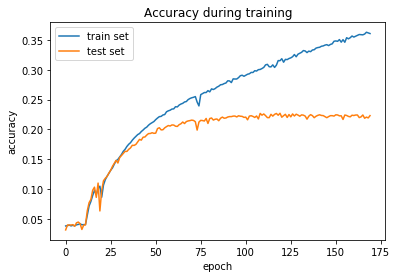

In [12]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Precision-recall

In [13]:
probability = classifier.predict_proba(vectors_test)
classList = integer_encoder.classes_

In [14]:
realLabel = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classList), axis=1), np.repeat(np.reshape(classList, (1, -1)), len(y_test), axis=0))
thresholds = np.arange(0, 1.001, 0.001)
precision = np.zeros((len(thresholds), len(classList)))
recall = np.zeros((len(thresholds), len(classList)))

for i, threshold in enumerate(thresholds):
    predictedLabel = probability >= threshold

    truePoz = (predictedLabel & realLabel).sum(axis = 0)
    falsePoz = (predictedLabel & (realLabel == False)).sum(axis = 0)
    falseNeg = ((predictedLabel == False) & realLabel).sum(axis = 0)

    precision[i, :] = truePoz / (truePoz + falsePoz)
    recall[i, :] = truePoz / (truePoz + falseNeg)
    
averagePrecision = np.nanmean(precision, axis=1)
averageRecall = np.nanmean(recall, axis=1)
minPrecision = np.nanmin(precision, axis=1)
maxPrecision = np.nanmax(precision, axis=1)

Text(0, 0.5, 'precision')

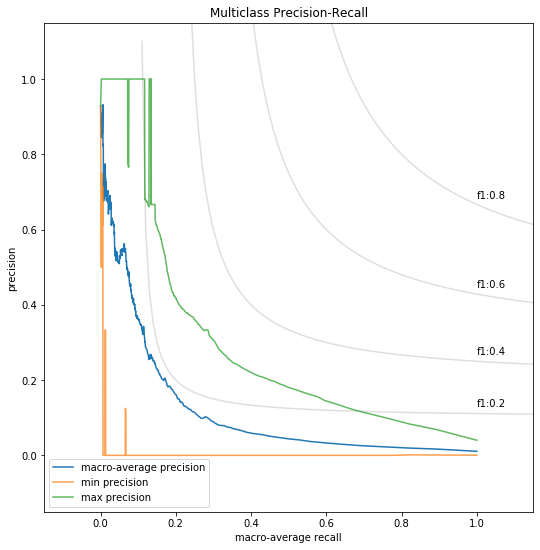

In [15]:
plt.figure(figsize=(9,9))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1.15, 115)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.25)
    plt.annotate('f1:{0:0.1f}'.format(f_score), xy=(1, y[100] + 0.02))

plt.plot(averageRecall, averagePrecision, label="macro-average precision")
plt.plot(averageRecall, minPrecision, label="min precision", alpha=0.75)
plt.plot(averageRecall, maxPrecision, label="max precision", alpha=0.75)

plt.xlim([-.15, 1.15])
plt.ylim([-.15, 1.15])
plt.gca().set_aspect('equal')
plt.legend(loc="lower left")
plt.title("Multiclass Precision-Recall")
plt.xlabel("macro-average recall")
plt.ylabel("precision")

In [16]:
maxProbability = probability.max(axis=1)
classifiedProportion = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    classifiedProportion[i] = (maxProbability >= threshold).sum() / len(maxProbability)

Text(0.5, 1.0, 'Precision & Recall')

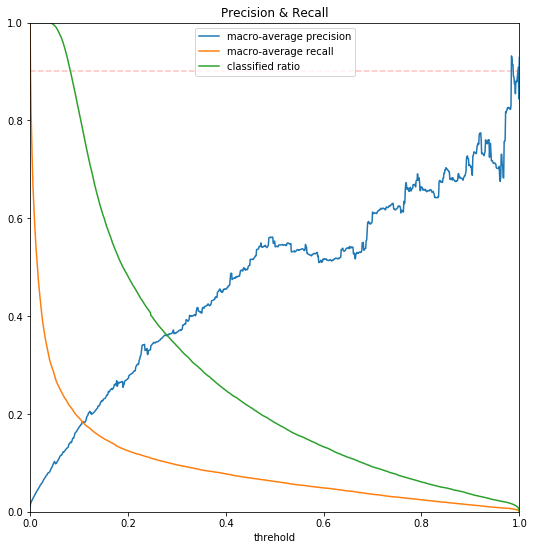

In [22]:
plt.figure(figsize=(9,9))

plt.axhline(0.9, color="red",linestyle='dashed', alpha=0.25)
plt.plot(thresholds, averagePrecision, label="macro-average precision")
plt.plot(thresholds, averageRecall, label="macro-average recall")
plt.plot(thresholds, classifiedProportion, label="classified ratio")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="upper center")
plt.xlabel("threhold")
plt.title("Precision & Recall")

In [18]:
threshold90 = thresholds[averagePrecision >= 0.9].min()
recall90 = averageRecall[threshold90 == thresholds][0]
print("To reach a multiclass average precision more than 90%, the minimum threshold is " + str(threshold90) + "; the corresponding multiclass average recall is " + str(recall90) + ". ")

To reach a multiclass average precision more than 90%, the minimum threshold is 0.984; the corresponding multiclass average recall is 0.0062019492833208035. 
